In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')
# device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())
    
from mpl_toolkits.axes_grid1 import make_axes_locatable

cpu


In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5
    

In [3]:
x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,3000,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

xyt_tensor = torch.from_numpy(xyt).float().to(device)

# initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

# DBC_pts = (Y == 0).reshape(-1,)


# NBC_pts_x0 = (X == 0).reshape(-1,)
# NBC_pts_x1 = (X == 1).reshape(-1,)

# NBC_pts_y0 = (Y == 0).reshape(-1,)
# NBC_pts_y1 = (Y == 1).reshape(-1,)

# xyt_initial = xyt[initial_pts,:]
# xyt_DBC = xyt[DBC_pts,:]

# xyt_NBC_x0 = xyt[NBC_pts_x0,:]
# xyt_NBC_x1 = xyt[NBC_pts_x1,:]

# #xyt_NBC_y0 = xyt[NBC_pts_y0,:]
# xyt_NBC_y1 = xyt[NBC_pts_y1,:]

# u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
# u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

# xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
# #xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
# xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
# #xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
# xyt_NBC_y = np.vstack((xyt_NBC_y1))

# u_I_DBC = np.vstack((u_initial,u_DBC))


lb_xyt = xyt[0]
ub_xyt = xyt[-1]

prob_name = "3D_HTTP_"

In [4]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                    

class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)         
            
        a = self.linears[-1](a) 
         
        return a

    
class Sequentialmodel_swish(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.iter = 0

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    
class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
class Sequentialmodel_rowdy(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
                
        a = self.linears[-1](a) 
         
        return a
                        

In [7]:
prob_name

'3D_HTTP_'

In [5]:
xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
layers =  np.array([3,50,50,50,1])

beta_init = 1.0

n_val_atanh = 1.0

n_val_rowdy = 1.0
rowdy_terms = 6

level = "low"

model_stan = Sequentialmodel_stan(layers,beta_init)
model_tanh = Sequentialmodel_tanh(layers)
model_atanh = Sequentialmodel_atanh(layers,n_val_atanh)
model_swish = Sequentialmodel_swish(layers)
model_rowdy = Sequentialmodel_rowdy(layers,n_val_rowdy,rowdy_terms)

model_stan.to(device)
model_tanh.to(device)
model_atanh.to(device)
model_swish.to(device)
model_rowdy.to(device)

u_pred_stan = np.zeros((xyt.shape[0],1))
u_pred_tanh = np.zeros((xyt.shape[0],1))
u_pred_atanh = np.zeros((xyt.shape[0],1))
u_pred_swish = np.zeros((xyt.shape[0],1))
u_pred_rowdy = np.zeros((xyt.shape[0],1))

models_n = 1

for i in range(4,5):
    model_stan.load_state_dict(torch.load('./HTTP/stan/' + prob_name+ 'stan_' + level +'_'+str(i)+'.pt'))
    u_pred_stan = u_pred_stan + model_stan.forward(xyt_tensor).cpu().detach().numpy()
    del model_stan
    
    model_tanh.load_state_dict(torch.load('./HTTP/tanh/' + prob_name+'tanh_'+ level +'_'+str(i)+'.pt'))
    u_pred_tanh = u_pred_tanh + model_tanh.forward(xyt_tensor).cpu().detach().numpy()
    del model_tanh
    
    model_rowdy.load_state_dict(torch.load('./HTTP/rowdy/'+ prob_name+ 'rowdy_' + level +'_'+str(i)+'.pt'))
    u_pred_rowdy = u_pred_rowdy + model_rowdy.forward(xyt_tensor).cpu().detach().numpy()
    del model_rowdy
    
    model_swish.load_state_dict(torch.load('./HTTP/swish/'+ prob_name+ 'swish_' + level +'_'+str(i)+'.pt'))
    u_pred_swish = u_pred_swish + model_swish.forward(xyt_tensor).cpu().detach().numpy()
    del model_swish

    model_atanh.load_state_dict(torch.load('./HTTP/atanh/' + prob_name+ 'atanh_' + level +'_'+str(i)+'.pt'))
    u_pred_atanh = u_pred_atanh + model_atanh.forward(xyt_tensor).cpu().detach().numpy()
    del model_atanh
    
u_pred_stan = u_pred_stan/models_n
u_pred_tanh = u_pred_tanh/models_n
u_pred_atanh = u_pred_atanh/models_n
u_pred_swish = u_pred_swish/models_n
u_pred_rowdy = u_pred_rowdy/models_n

u_pred = np.hstack((u_pred_stan,u_pred_tanh,u_pred_atanh,u_pred_swish,u_pred_rowdy))

In [6]:
fea_data = scipy.io.loadmat('HTTP_FEA_full_'+level+'.mat')
u_fea = np.array(fea_data['u_full'])

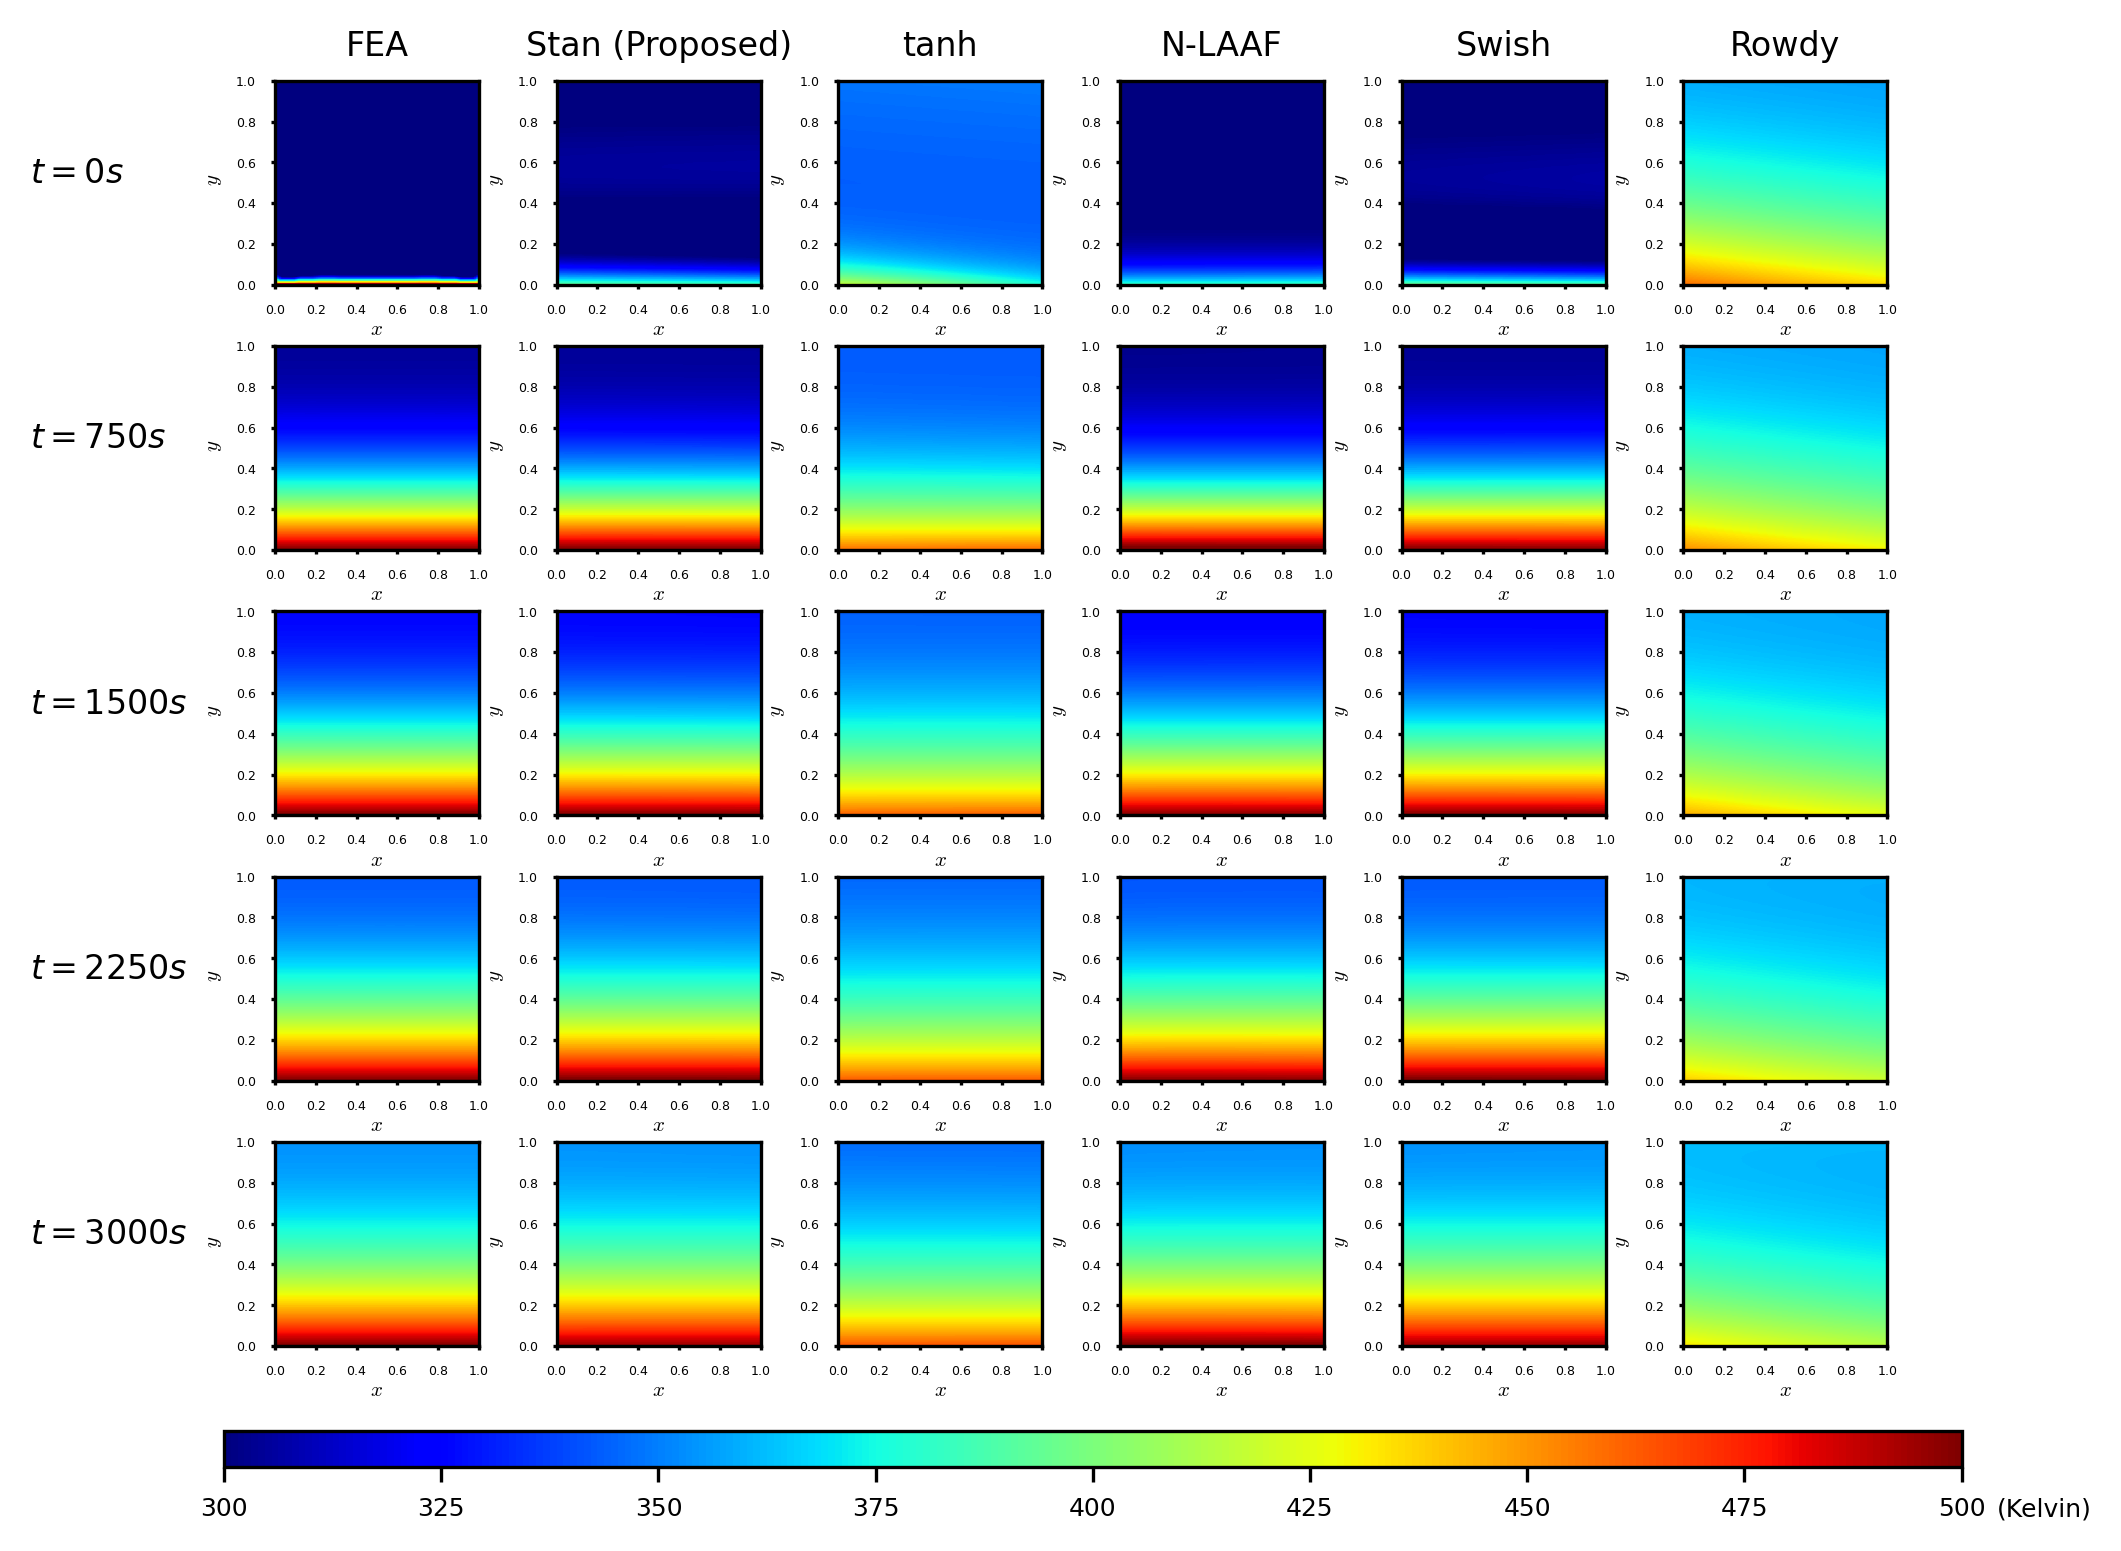

In [11]:
fig, ax = plt.subplots(5,6)
fig.dpi=300
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.4, hspace=0.3)
t_steps = [0,24,49,74,99]


for R in range(5):

    cmap = plt.cm.jet

    u_fea_3d = np.flipud(np.transpose(u_fea[:,t_steps[R]].reshape(100,100)))
    # ax[R,0].figure.set_size_inches(100,100)
    img = ax[R,0].imshow(u_fea_3d,vmin = 300,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 1)

    ax[R,0].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
    ax[R,0].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

    ax[R,0].tick_params(axis='x', labelsize=3,length = 1)
    ax[R,0].tick_params(axis='y', labelsize=3,length = 1)

    ax[R,0].yaxis.set_label_coords(-0.25,0.5)

    for i in range(1,6):
        # ax[R,i].figure.set_size_inches(20,20)
        u_pred_3d = u_pred[:,i-1].reshape(100,100,100, order = 'F')
        img = ax[R,i].imshow(np.flipud(u_pred_3d[:,:,t_steps[R]]),vmin = 300,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 1)

        ax[R,i].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
        ax[R,i].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

        ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
        ax[R,i].tick_params(axis='y', labelsize=3,length = 1)

        ax[R,i].yaxis.set_label_coords(-0.25,0.5)


cbaxes = fig.add_axes([0.075, -0.005, 0.905 , 0.025]) 

plot_rows = ['$t=0s$','$t=750s$','$t=1500s$','$t=2250s$','$t=3000s$']

for i in range(5):
    ax[i,0].text(-1.2,0.5,plot_rows[i],fontsize=8,transform=ax[i,0].transAxes)
    

# cbar = fig.colorbar(img, ax=ax,location = 'bottom',orientation = 'horizontal', aspect = 50, panchor = (0,10),pad = 0.9)
cbar = fig.colorbar(img,cax = cbaxes,orientation = 'horizontal', aspect = 1/50, panchor = (0,10),pad = 0.9)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 
cbar.ax.text(1.02,-1.35,"(Kelvin)",fontsize=6, transform=cbar.ax.transAxes)

# ax[0,0].set_title('Time Steps',fontsize=8, math_fontfamily='cm')
ax[0,0].set_title('FEA',fontsize=8, math_fontfamily='cm')
ax[0,1].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[0,2].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[0,3].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[0,4].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[0,5].set_title('Rowdy',fontsize=8,math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.1, hspace=0.3)
# fig.subplots_adjust(bottom = 0.1)
plt.savefig('HTTP_prediction_'+level+'.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

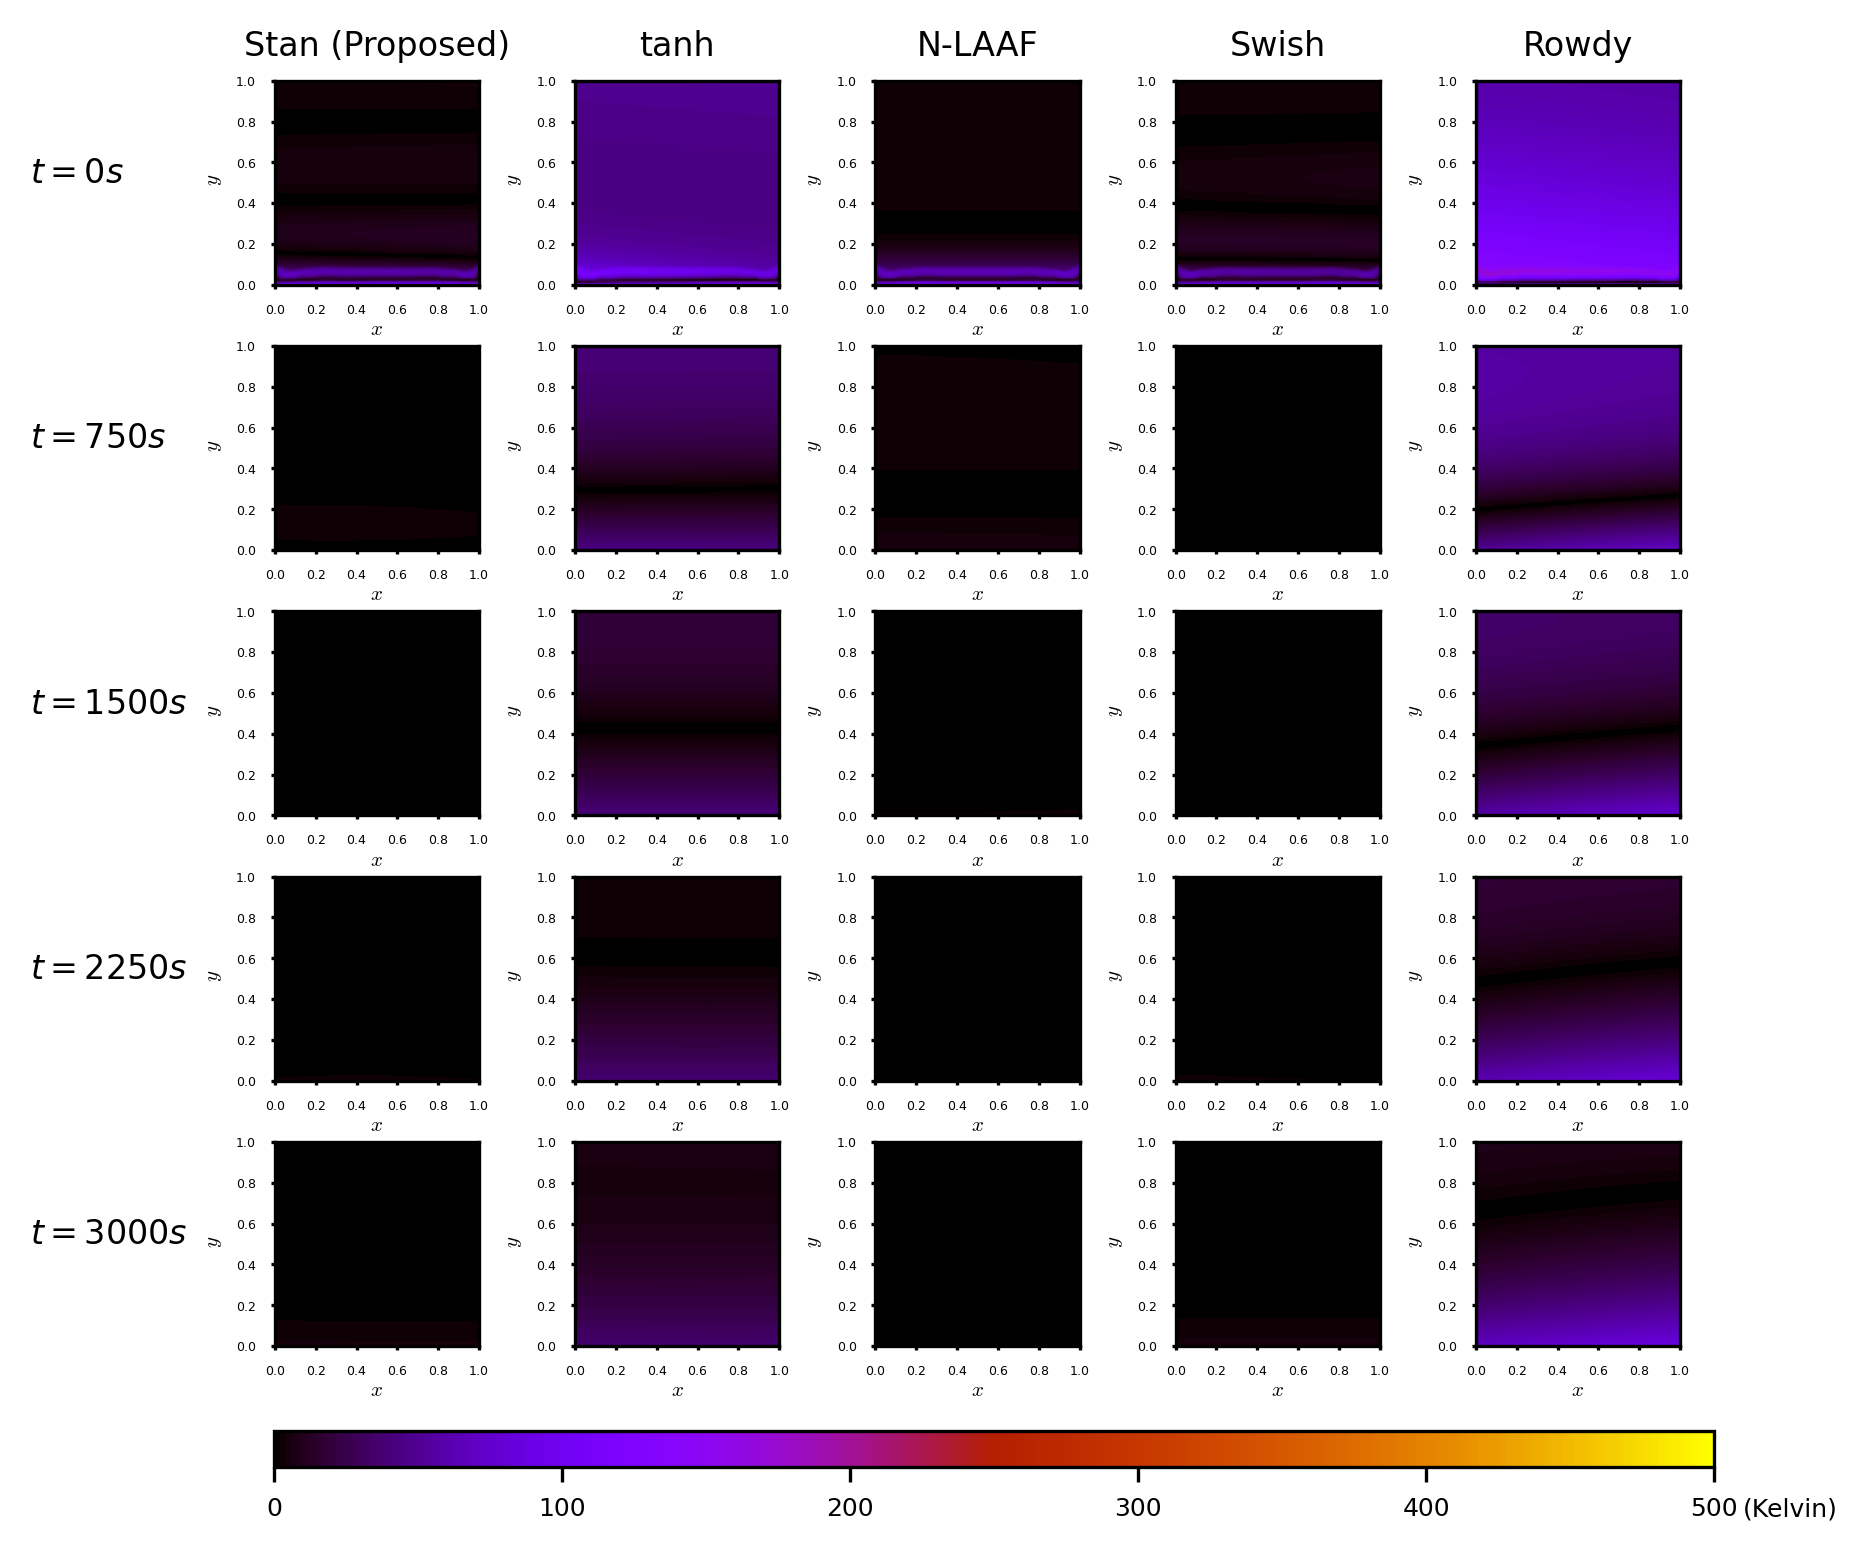

In [8]:
fig, ax = plt.subplots(5,5)
fig.dpi=300
fig.tight_layout()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.4, hspace=0.3)

t_steps = [0,24,49,74,99]

for R in range(5):

    cmap = plt.cm.gnuplot

    u_fea_3d = np.flipud(np.transpose(u_fea[:,t_steps[R]].reshape(100,100)))

    for i in range(5):
        u_pred_3d = u_pred[:,i].reshape(100,100,100,order = 'F')
        img = ax[R,i].imshow(np.abs(np.flipud(u_pred_3d[:,:,t_steps[R]])-u_fea_3d),vmin = 0,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 1)

        ax[R,i].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
        ax[R,i].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

        ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
        ax[R,i].tick_params(axis='y', labelsize=3,length = 1)

        ax[R,i].yaxis.set_label_coords(-0.25,0.5)


cbaxes = fig.add_axes([0.15, -0.005, 0.75 , 0.025]) 


cbar = fig.colorbar(img,cax = cbaxes,orientation = 'horizontal', aspect = 1/50, panchor = (0,10),pad = 0.9)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False)  
cbar.ax.text(1.02,-1.35,"(Kelvin)",fontsize=6, transform=cbar.ax.transAxes)


plot_rows = ['$t=0s$','$t=750s$','$t=1500s$','$t=2250s$','$t=3000s$']

for i in range(5):
    ax[i,0].text(-1.2,0.5,plot_rows[i],fontsize=8,transform=ax[i,0].transAxes)


ax[0,0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[0,1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[0,2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[0,3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[0,4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')


plt.savefig('HTTP_error_comparison.pdf', format='pdf',pad_inches=0, bbox_inches='tight')